## Homework 4 - DSE 220: Machine Learning
English words embedding and clustering
* data preprocessing
* embedding
* nearest neighbor
* Clustering

### data preprocessing ###

**1**. First, download the Brown corpus (using nltk.corpus). This is a collection of text samples from a wide range of sources, with a total of over a million words. Calling brown.words() returns this text in one long list, which is useful.

In [1]:
from nltk.corpus import brown
import nltk
nltk.data.path.append("c:/wenyan/dse/w9yan/nltk_data")
#nltk.download()
brown_words = brown.words()

**2**. Remove stopwords and punctuation, make everything lowercase, and count how often each word occurs. Use this to come up with two lists:
* A vocabulary V , consisting of a few thousand (e.g., 5000) of the most commonly-occurring words.
* A shorter list C of at most 1000 of the most commonly-occurring words, which we shall call context words.

In [2]:
import re
stopwords = nltk.corpus.stopwords.words('english')
valid_words = [w.lower() for w in brown_words if w.lower() not in stopwords and re.search('^[a-z]+$', w.lower()) ]

In [3]:
from collections import Counter
word_cnt = Counter(valid_words)
vocabulary_count = word_cnt.most_common(5000)
context_count = word_cnt.most_common(1000)
vocabulary = [word[0] for word in vocabulary_count]
context = [word[0] for word in context_count]

**3**. For each word w in V , and each occurrence of it in the text stream, look at the surrounding window of four words (two before, two after): w1 w2 w w3 w4.

Keep count of how often context words from C appear in these positions around word w. That is, for w in V , c in C, define n(w,c) = # of times c occurs in a window around w.

Using these counts, construct the probability distribution Pr(c|w) of context words around w (for each w in V ), as well as the overall distribution Pr(c) of context words. These are distributions over C.


In [4]:
count_c_around_w = {(w,c):0 for w in vocabulary for c in context}
context_dict = {c:True for c in context}
vocabulary_dict = {w:True for w in vocabulary}
for i in range(2, len(valid_words)-2):
    c = [0 for i in range(4)]
    c[0],c[1],w,c[2],c[3] = valid_words[i-2:i+3]
    if w not in vocabulary_dict: continue
    for i in range(4):
        if c[i] in context_dict:
            count_c_around_w[(w,c[i])] += 1
            
# deal with 1st two and last two
l = len(valid_words)
for j in [0,1,l-2,l-1]:
    w = valid_words[j]
    if w not in vocabulary_dict: continue
    for i in range(j+1,j+3):
        if i >= l: break
        c = valid_words[i]
        if c in context_dict:
            count_c_around_w[(w,c)] += 1
    for i in range(j-2,j):
        if i < 0: break
        c = valid_words[i]
        if c in context_dict:
            count_c_around_w[(w,c)] += 1


In [5]:
# P(c)=∑wn(w,c)/∑c′∑wn(w,c′)
# P(c|w)=n(w,c)/∑c′n(w,c′)
total_per_vocabulary = {w:0 for w in vocabulary}
for (w,c) in count_c_around_w:
    total_per_vocabulary[w] += count_c_around_w[(w,c)]
# plus 1 smoothing for Pr(c|w)
prob_c_under_w = {(w,c): count_c_around_w[(w,c)]+1 / total_per_vocabulary[w]+1000 for w in vocabulary for c in context}

total_per_context = {c:0 for c in context}
for (w,c) in count_c_around_w:
    total_per_context[c] += count_c_around_w[(w,c)]
total_occurance = sum(total_per_vocabulary.values())
prob_context = {c: total_per_context[c]/total_occurance for c in context}

**4**. Represent each vocabulary item w by a |C|-dimensional vector psi(w), whose c'th coordinate is: 

psi(w) = max(0, log(Pr(c|w)/Pr(c)))

This is known as the (positive) pointwise mutual information, and has been quite successful in work on word embedding.

In [6]:
from math import log
import pandas as pd

def make_vector(w):
    return [max(0, log(prob_c_under_w[(w,c)]/prob_context[c])) for c in context]

vector_vocabulary = [[w]+make_vector(w) for w in vocabulary]

X = pd.DataFrame(vector_vocabulary)
X.columns = ['w']+context

In [7]:
X.ix[:10,1:]

,one,would,said,new,could,time,two,may,first,like,...,lord,success,remain,principal,leadership,jack,obvious,fell,thin,pieces
0,11.253008,11.429298,11.771546,11.879305,11.917345,11.923118,12.109214,12.062338,12.061258,12.208432,...,14.787721,14.713512,14.732785,14.729970,14.731785,14.808154,14.684853,14.796544,14.848437,14.767510
1,11.244686,11.422777,11.780935,11.871485,11.889525,11.892639,12.046635,12.016544,12.047679,12.250911,...,14.783741,14.712514,14.739753,14.724982,14.731785,14.810148,14.681858,14.791557,14.847437,14.766511
2,11.228775,11.422777,11.752497,11.860632,11.895345,11.879007,12.037790,12.031388,12.034902,12.196793,...,14.786728,14.711514,14.731785,14.725982,14.732785,14.814124,14.684854,14.792556,14.850433,14.766511
3,11.197148,11.373940,11.721245,11.910932,11.868886,11.875078,12.035813,12.019530,12.045724,12.179076,...,14.780746,14.712514,14.731785,14.725982,14.732785,14.807155,14.681858,14.791557,14.848437,14.766511
4,11.225941,11.382733,11.746712,11.859639,11.879750,11.883897,12.035813,12.017540,12.033913,12.186003,...,14.782744,14.714510,14.731785,14.724982,14.732785,14.810148,14.682858,14.791557,14.848437,14.767510
5,11.234420,11.388553,11.733079,11.868537,11.886603,11.959954,12.036802,12.032370,12.103698,12.189940,...,14.781746,14.711514,14.733783,14.725982,14.732785,14.806156,14.682858,14.791557,14.847437,14.766511
6,11.254848,11.376880,11.726193,11.863603,11.872850,11.871133,12.040747,12.023499,12.074656,12.182051,...,14.780746,14.711514,14.734781,14.729970,14.731785,14.806156,14.683856,14.791557,14.849435,14.776461
7,11.219297,11.358114,11.731117,11.858646,11.865902,11.878026,12.034824,12.052769,12.032922,12.174098,...,14.781746,14.716502,14.732785,14.725982,14.732785,14.806156,14.683856,14.792557,14.847437,14.769507
8,11.207802,11.378835,11.724217,11.874425,11.871861,11.938939,12.075566,12.022508,12.039836,12.177088,...,14.783742,14.712514,14.731785,14.725982,14.732785,14.807155,14.685850,14.792557,14.847437,14.767510
9,11.206838,11.433930,11.737969,11.859639,11.875813,11.877044,12.034824,12.015546,12.028950,12.178083,...,14.782744,14.712514,14.731785,14.724983,14.731785,14.809151,14.682858,14.792557,14.851430,14.766511


### Embedding ###
- Suppose we want a 100-dimensional representation. How would you achieve this?

Tried both SVD and PCA although SVD is my choice.

In [8]:
#SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X.ix[:,1:]) 

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X.ix[:,1:])

**6**. Investigate the resulting embedding in two ways:
* Try finding the nearest neighbor of selected words. Do the answers make sense?
* Cluster the vocabulary into 100 clusters. Look them over; do they seem completely random, or is there some sense to them?

### Nearest neighbor results ###

Pick a collection of 25 words w from V. For each w, return its nearest neighbor w0 != w in V. A popular distance measure to use for this is cosine distance:

1 -	psi(w).psi(w0) / (||psi(w)|| * ||psi(w0)||)

Here are some suggestions for words you might choose:
communism, autumn, cigarette, pulmonary, mankind, africa, chicago, rev-
olution, september, chemical, detergent, dictionary, storm, worship

Do the results make any sense? You can use other distance measures apart from cosine distance to improve the results. (20 marks)

In [9]:
import numpy as np
check_words = ['communism', 'autumn', 'cigarette', 'pulmonary', 'mankind', 'africa', 'chicago', 'revolution', 'september', 'chemical', 'detergent', 'dictionary', 'storm', 'worship', 'war', 'problem', 'wall', 'department', 'society', 'company', 'college', 'public', 'money', 'wife', 'wanted']
check_words_index = [vocabulary.index(w) for w in check_words]

def compute_distance(v0, v1):
    dist= 1 - np.dot(v0,v1) / (np.linalg.norm(v0) * np.linalg.norm(v1))
    return dist

def find_nearest_neighbor(X):
    for j in check_words_index:
        nearest_neighbor = -1
        nearest_dist = 1000
        v0 = X[j]
        w0 = vocabulary[j]
        for i in range(len(vocabulary)):
            if i == j: continue
            v1 = X[i]
            dist = compute_distance(v0, v1)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_neighbor = i
        w1 = vocabulary[nearest_neighbor]
        print("nearest neighbor of {} - {}".format(w0, w1))

In [10]:
find_nearest_neighbor(X_pca)

nearest neighbor of communism - losing
nearest neighbor of autumn - tournament
nearest neighbor of cigarette - pitch
nearest neighbor of pulmonary - disk
nearest neighbor of mankind - judgments
nearest neighbor of africa - carolina
nearest neighbor of chicago - university
nearest neighbor of revolution - journey
nearest neighbor of september - january
nearest neighbor of chemical - symbolic
nearest neighbor of detergent - fabrics
nearest neighbor of dictionary - text
nearest neighbor of storm - weekend
nearest neighbor of worship - skywave
nearest neighbor of war - free
nearest neighbor of problem - fact
nearest neighbor of wall - street
nearest neighbor of department - welfare
nearest neighbor of society - community
nearest neighbor of company - power
nearest neighbor of college - university
nearest neighbor of public - education
nearest neighbor of money - better
nearest neighbor of wife - woman
nearest neighbor of wanted - want


In [11]:
find_nearest_neighbor(X_svd)

nearest neighbor of communism - losing
nearest neighbor of autumn - tournament
nearest neighbor of cigarette - pitch
nearest neighbor of pulmonary - disk
nearest neighbor of mankind - defeat
nearest neighbor of africa - carolina
nearest neighbor of chicago - carleton
nearest neighbor of revolution - resumed
nearest neighbor of september - january
nearest neighbor of chemical - description
nearest neighbor of detergent - mustard
nearest neighbor of dictionary - text
nearest neighbor of storm - aristotle
nearest neighbor of worship - produces
nearest neighbor of war - free
nearest neighbor of problem - subject
nearest neighbor of wall - block
nearest neighbor of department - secretary
nearest neighbor of society - politics
nearest neighbor of company - letters
nearest neighbor of college - university
nearest neighbor of public - education
nearest neighbor of money - drink
nearest neighbor of wife - husband
nearest neighbor of wanted - maybe


### Clustering ###

Using the vectorial representation 	psi(), cluster the words in V into 100 groups. Clearly specify what algorithm and distance function you using for this, and the reasons for your choices.

Look over the resulting 100 clusters. Do any of them seem even moderately coherent? Pick out a few of the best clusters and list the words in them. (30 marks)

* Both Kmeans++ and EM(GaussianMixture) are tried here although EM is my choice.
* For Kmeans++, also tried to find best value for param n_init based on inertia, both embedding of PCA and SVD are experimented with.
* For GaussianMixture, tried all covariance type and decided to use 'full' for covariance.

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def check_kmeans_n_init(X):
    inertia = []
    n_init_list = np.arange(1,30,5)

    for n in n_init_list: 
        k_means = KMeans(n_clusters=100, n_init=n, init='k-means++', random_state=5) 
        k_means.fit(X)
        inertia.append(k_means.inertia_)
    plt.plot(n_init_list, inertia)
    plt.show()

def group_with_kmeans(X, n):
    inertia = []
    k_means = KMeans(n_clusters=100, n_init=n, init='k-means++', random_state=5) 
    k_means.fit(X)
    return k_means.labels_

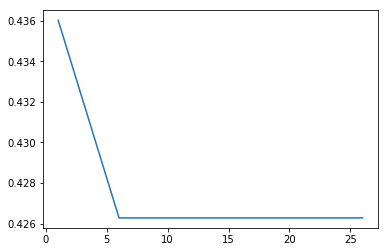

In [13]:
check_kmeans_n_init(X_svd)

In [15]:
# check svd grouping
X['label'] = group_with_kmeans(X_svd, 6)

# print groups out of 100 which has more than 5 words
max_group = []
for i in range(100):
    group = X[X['label']==i]['w'].tolist()
    length = len(group)
    if length > len(max_group): max_group = group
    if length < 30 and length >3:
        print(group)
print("\nmax group:",len(max_group))

['never', 'know', 'say', 'think']
['government', 'president', 'america', 'nations']
['later', 'several', 'four', 'five', 'past', 'six', 'ten']
['small', 'general', 'less', 'enough', 'far', 'end', 'order', 'possible', 'early', 'case', 'need', 'become', 'perhaps', 'seem']
['system', 'social', 'political', 'economic']
['around', 'went', 'got', 'going']
['american', 'part', 'number', 'fact', 'hand', 'point', 'side', 'large', 'best', 'least', 'example']
['age', 'following', 'century', 'million', 'recent', 'miles', 'earlier', 'nearly', 'throughout', 'month', 'couple', 'fiscal', 'lived', 'seven', 'married', 'spent', 'eight', 'june', 'dollars', 'thousand', 'older', 'nine', 'twenty', 'fifty', 'thirty', 'fifteen', 'forty']
['program', 'business', 'national', 'development', 'interest', 'service', 'law', 'local', 'college', 'federal', 'board', 'community', 'court', 'department', 'policy', 'education', 'university', 'washington', 'schools', 'secretary', 'administration']
['home', 'thought', 'left',

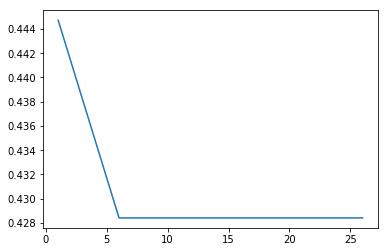

In [16]:
check_kmeans_n_init(X_pca)

In [17]:
# check pca grouping
X['label'] = group_with_kmeans(X_pca, 6)

In [18]:
# print groups out of 100 which has more than 5 words
for i in range(100):
    group = X[X['label']==i]['w'].tolist()
    if len(group) > 3 and len(group) < 30:
        print(group)

['little', 'right', 'thought', 'say', 'something', 'think']
['give', 'become', 'help', 'probably', 'turn', 'cost', 'seem', 'provide', 'run', 'leave', 'believe', 'soon', 'longer', 'call', 'expected', 'hope', 'bring', 'expect']
['however', 'part', 'fact', 'less', 'point', 'present', 'important', 'early', 'need', 'perhaps']
['since', 'place', 'every', 'end', 'next', 'days', 'second', 'half']
['great', 'used', 'use', 'found', 'almost', 'possible', 'things', 'children', 'best', 'others', 'times', 'seen']
['left', 'hand', 'side', 'thing']
['might', 'without', 'around', 'course', 'always', 'away', 'enough', 'far', 'better', 'told', 'nothing', 'find', 'going', 'asked', 'knew', 'felt', 'want', 'done', 'anything', 'really', 'tell', 'sure']
['later', 'several', 'five', 'past', 'ten']
['city', 'development', 'members', 'central', 'england', 'birth', 'orleans', 'jersey']
['came', 'home', 'went', 'got', 'put', 'head', 'turned']
['order', 'form', 'thus', 'line', 'lines', 'values', 'space', 'range', '

#### EM(GaussianMixture) ####

In [19]:
# EM clustering
from sklearn.mixture import GaussianMixture

for cov_type in ['spherical', 'diag', 'tied', 'full']:
#for iter in [5, 10, 20, 40]:
    gmm = GaussianMixture(n_components=100, covariance_type=cov_type, random_state=0)
    gmm.fit(X_svd)
    print("cov_type:{}, log likelihood:{}".format(cov_type,gmm.lower_bound_))

cov_type:spherical, log likelihood:557.1509100504013
cov_type:diag, log likelihood:559.6455782429762
cov_type:tied, log likelihood:548.8795062419473
cov_type:full, log likelihood:572.0598569310584


In [20]:
gmm = GaussianMixture(n_components=100, covariance_type='full', random_state=0)
gmm.fit(X_svd)
X['label'] = gmm.predict(X_svd)
# print groups out of 100 which has more than 5 words
for i in range(100):
    group = X[X['label']==i]['w'].tolist()
    if len(group) > 3 and len(group) < 30:
        print(group)

['john', 'god', 'name', 'death', 'word', 'words', 'miss', 'heard', 'boy', 'love', 'wife', 'voice', 'woman', 'girl', 'mother', 'mean', 'alone', 'gone', 'father', 'dead', 'son', 'police', 'hear', 'yes', 'remember', 'oh']
['also', 'used', 'use', 'find']
['since', 'american', 'however', 'part', 'number', 'less', 'given', 'order', 'form', 'thus']
['say', 'told', 'nothing', 'knew', 'give', 'want', 'anything', 'really', 'tell', 'sure']
['second', 'early', 'half', 'period', 'close', 'short', 'million', 'third', 'spent']
['good', 'still', 'come', 'thought', 'think']
['great', 'something', 'look', 'things', 'thing']
['later', 'several', 'four', 'five', 'past', 'six', 'recent', 'hundred', 'ten']
['put', 'head', 'eyes', 'toward', 'room', 'turned', 'open', 'feet', 'across', 'car', 'behind', 'street', 'front', 'stood', 'moved', 'walked', 'opened']
['law', 'federal', 'department', 'secretary']
['general', 'public', 'system', 'program', 'business', 'group', 'national', 'within', 'development', 'intere